# 3章 一般化線形モデル(GLM)

## 3.3 統計モデリングの前にデータを図示する

In [4]:
df = pd.read_csv('./data3a.csv')

In [5]:
df.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


In [6]:
def draw_scatter(df):
    plt.scatter(df[df.f=='C'].x, df[df.f=='C'].y, color='r')
    plt.scatter(df[df.f=='T'].x, df[df.f=='T'].y, color='b')
    plt.legend([u'f == C', 'f == T'], loc='upper left')

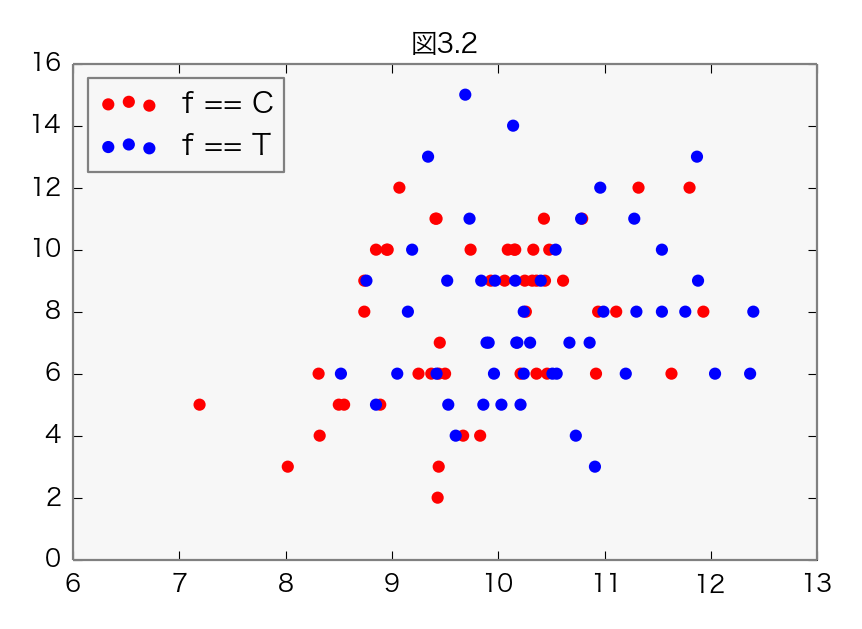

In [7]:
draw_scatter(df)
plt.title(u'図3.2')

In [8]:
# pandasだと一つにできない??
# df.groupby(df.f).plot(x='x', y='y', kind='scatter', )

(0, 15)

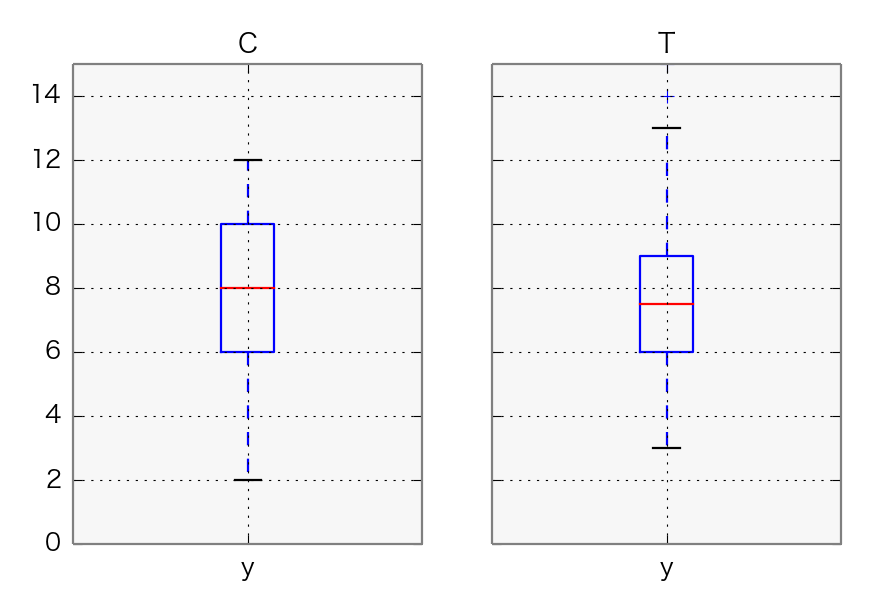

In [11]:
df.groupby(df.f).boxplot(column='y')
plt.ylim(0, 15)

ある個体$i$において種子数が$y_i$である確率$p(y_i|\lambda_i)$はポアソン分布にしたがっていて、
### $p(y_i|\lambda_i) = \frac{\lambda^{yi}_iexp(-\lambda_i)}{y_i!}$
と仮定する

## 3.4.1 線形予測と対数リンク関数

ある個体$i$の平均種子数$\lambda_i$が
### $\lambda_i = exp(\beta_1 + \beta_2x_i)$
であるとする。変形すると
### $log\lambda_i = \beta_1 + \beta_2x_i$
とできる。この時、右辺は**線形予測子**、左辺の「関数」は**リンク関数**とよばれる。

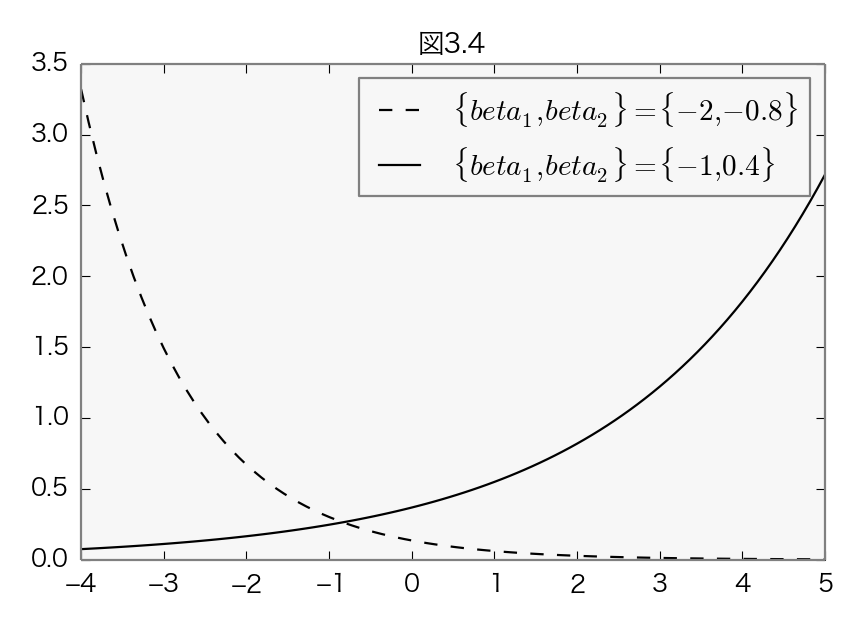

In [12]:
X = np.linspace(-4, 5, 100)
plt.plot(X, np.exp(-2 - 0.8*X), 'k--')
plt.plot(X, np.exp(-1 + 0.4*X), 'k-')
plt.legend(['$\{beta_1, beta_2\} = \{-2, -0.8\}$', '$\{beta_1, beta_2\} = \{-1, 0.4\}$'])
plt.title(u'図3.4')

## 3.4.2 あてはめと、あてはまりの良さ

ポワソン回帰により$\beta_1$と$\beta_2$を求める。

In [13]:
# 独自実装
def log_likelifood(b1, b2, x, y):
    # ポワソン回帰の対数尤度を返す
    ret = 0
    for i in range(x.size):
        ret += y[i] * (b1 + b2*x[i]) - np.exp(b1 + b2*x[i]) - sum(np.log(range(1, y[i])))
    return ret

def climb_b1(b2, x, y):
    # b2固定でb1を動かした時の最大の対数尤度を返す
    b1 = 1
    sign = +1
    alpha = 0.01

    logL = log_likelifood(b1, b2, x, y)
    
    while True:
        b1 += alpha * sign
        logL_n = log_likelifood(b1, b2, x, y)
        if np.abs(logL - logL_n) < 0.00001:
            break
        if logL_n < logL:
            sign = sign * -1
            alpha = alpha * 0.5
        else:
            alpha = alpha * 1.2
        logL = logL_n
    return logL, b1

def hill_climb(alpha, x, y):
    b1 = 1
    b2 = 0.1
    sign = +1
    
    max_logL, b1 = climb_b1(b2, x, y)
    
    while True:
        b2 += alpha * sign
        # b2を動かした時の対数尤度を出す
        max_logL_n, b1 = climb_b1(b2, x, y)
        # 変化しなくなったら終了
        if np.abs(max_logL_n - max_logL) < 0.00001:
            break
        if max_logL_n < max_logL:
            # 対数尤度が減ったら符号逆転
            sign = sign * -1
            alpha = alpha * 0.5
        else:
            alpha = alpha * 1.2            
        max_logL = max_logL_n
    print('Likelihood: %s, b1: %s, b2: %s' % (max_logL, b1, b2))
    return b1, b2

hill_climb(0.1, df.x.values, df.y.values)

Likelihood: -35.8338056943, b1: 1.29261566537, b2: 0.0755556824002


(1.2926156653749266, 0.07555568240017577)

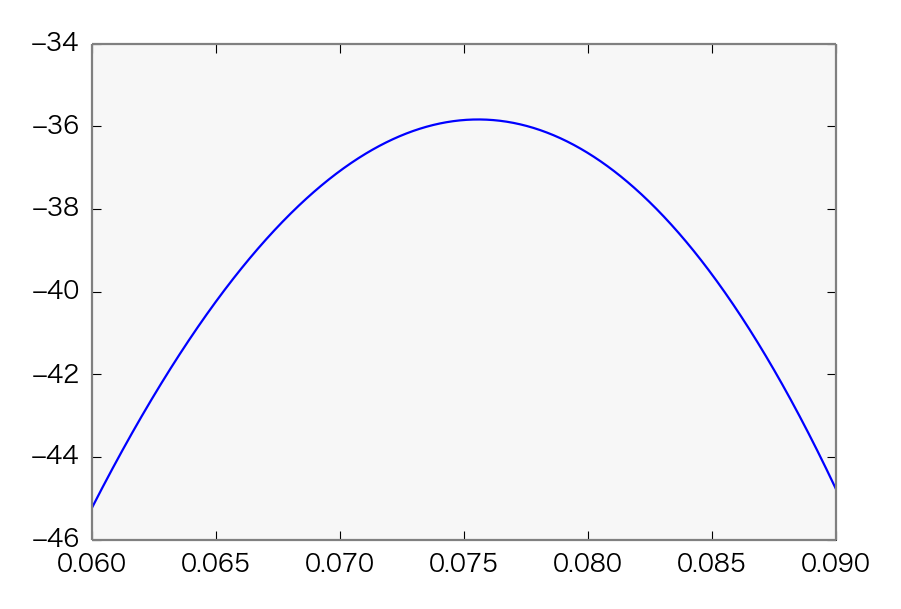

In [14]:
def plot_likelifood():
    X = np.linspace(0.06, 0.09, 1000)
    Y = []
    for x in X:
        Y.append(log_likelifood(1.2926, x, df.x.values, df.y.values))
    plt.plot(X, Y)
plot_likelifood()

statsmodelsを使うパターン

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import glm

def calc_x_related_model(df):
    return glm('y ~ x', data=df, family=sm.families.Poisson(sm.families.links.log)).fit()

In [16]:
x_related_model = calc_x_related_model(df)
x_related_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Wed, 11 Mar 2015   Deviance:                       84.993
Time:                        20:37:18   Pearson chi2:                     83.8
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000         0.579     2.005
x              0.0757      0.036      2.125      0.034         0.006     0.145
==============================================================================
"""

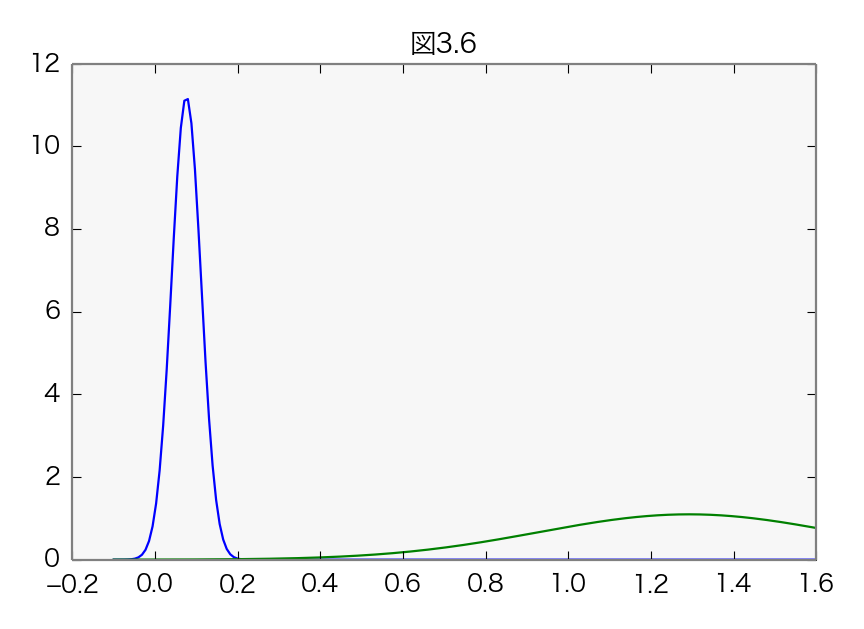

In [12]:
import scipy.stats
def plot_fig36(model):
    X = np.linspace(-0.1, 1.6, 200)
    plt.plot(X, scipy.stats.norm.pdf(X, loc=model.params[1], scale=model.bse[1]))
    plt.plot(X, scipy.stats.norm.pdf(X, loc=model.params.Intercept, scale=model.bse.Intercept))
    plt.title(u'図3.6')
    
plot_fig36(x_related_model)

対数尤度の評価

In [13]:
x_related_model.llf

-235.38625076986077

## 3.4.3 ポアソン回帰モデルによる予測

In [18]:
def draw_estimate_x(model):
    X = np.linspace(7, 13, 100)
    Y = model.predict({'x': X})
    plt.plot(X, Y, 'k-')

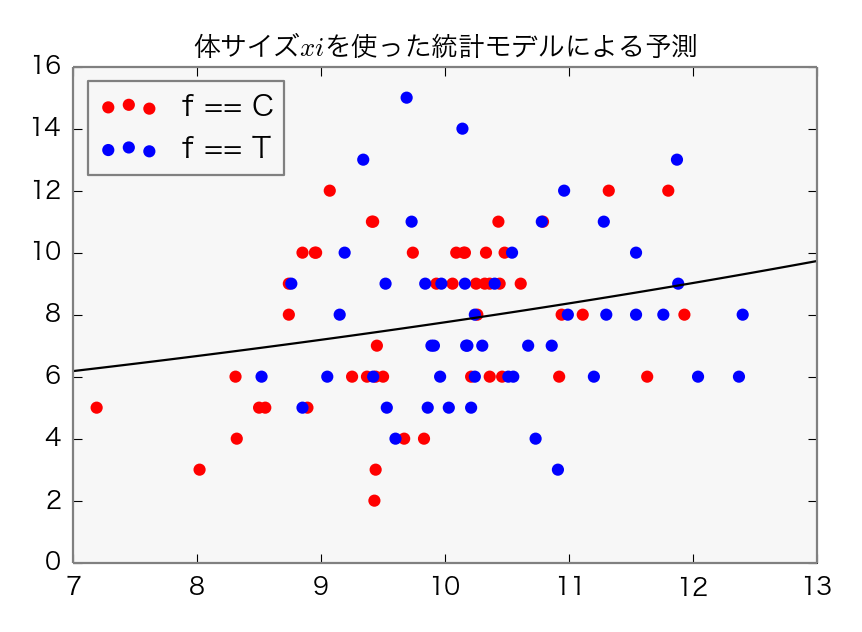

In [19]:
draw_scatter(df)
draw_estimate_x(x_related_model)
plt.xlim(7, 13)
plt.title(u'体サイズ$xi$を使った統計モデルによる予測')

## 3.5 説明変数が因子型の統計モデル

In [20]:
def calc_f_related_model(df):
    return glm('y ~ f', data=df, family=sm.families.Poisson(sm.families.links.log)).fit()

In [21]:
f_related_model = calc_f_related_model(df)
f_related_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Wed, 11 Mar 2015   Deviance:                       89.475
Time:                        20:37:40   Pearson chi2:                     87.1
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0516      0.051     40.463      0.000         1.952     2.151
f[T.T]         0.0128      0.071      0.179      0.858        -0.127     0.153
==============================================================================
"""

In [22]:
def draw_estimate_f(model):
    X = np.linspace(7, 14, 1000)
    Y = model.predict({'x': X, 'f': ['C']*len(X)})
    plt.plot(X, Y, 'r-')
    Y = model.predict({'x': X, 'f': ['T']*len(X)})
    plt.plot(X, Y, 'b-')

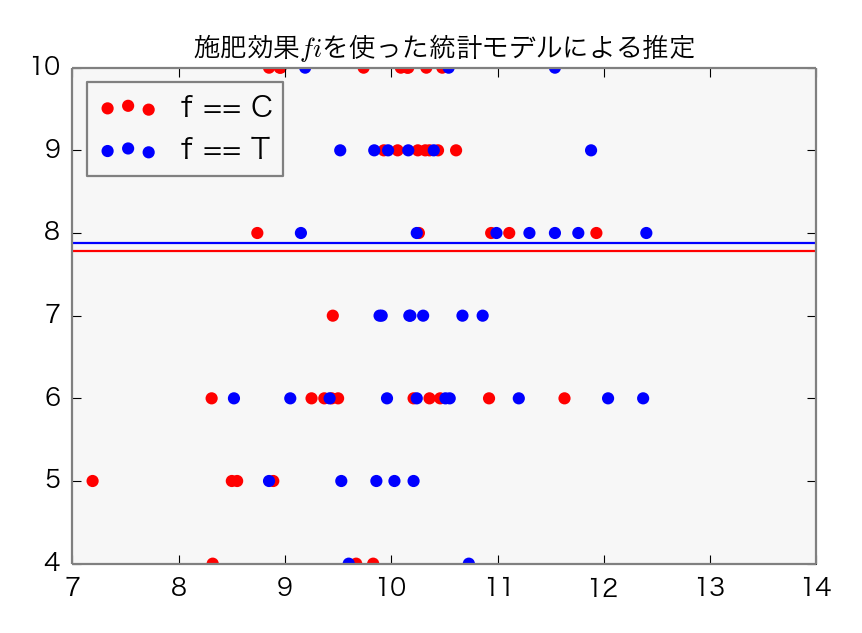

In [23]:
draw_scatter(df)
draw_estimate_f(f_related_model)
plt.xlim(7, 14)
plt.ylim(4, 10)
plt.title(u'施肥効果$fi$を使った統計モデルによる推定')

## 3.6 説明変数が数量型 + 因子型の統計モデル

In [24]:
def calc_x_f_related_model(df):
    return glm('y ~ x + f', data=df, family=sm.families.Poisson(sm.families.links.log)).fit()

In [25]:
x_f_related_model = calc_x_f_related_model(df)
x_f_related_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Wed, 11 Mar 2015   Deviance:                       84.808
Time:                        20:37:44   Pearson chi2:                     83.8
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.001         0.539     1.988
f[T.T]        -0.0320      0.074     -0.430      0.667        -0.178     0.114
x              0.0801      0.037      2.162      0.031         0.007     0.153
==============================================================================
"""

In [26]:
def draw_estimate_x_f(model):
    X = np.linspace(7, 13, 100)
    Y = model.predict({'x': X, 'f': ['C']*len(X)})
    plt.plot(X, Y, 'r-')
    Y = model.predict({'x': X, 'f': ['T']*len(X)})
    plt.plot(X, Y, 'b-')

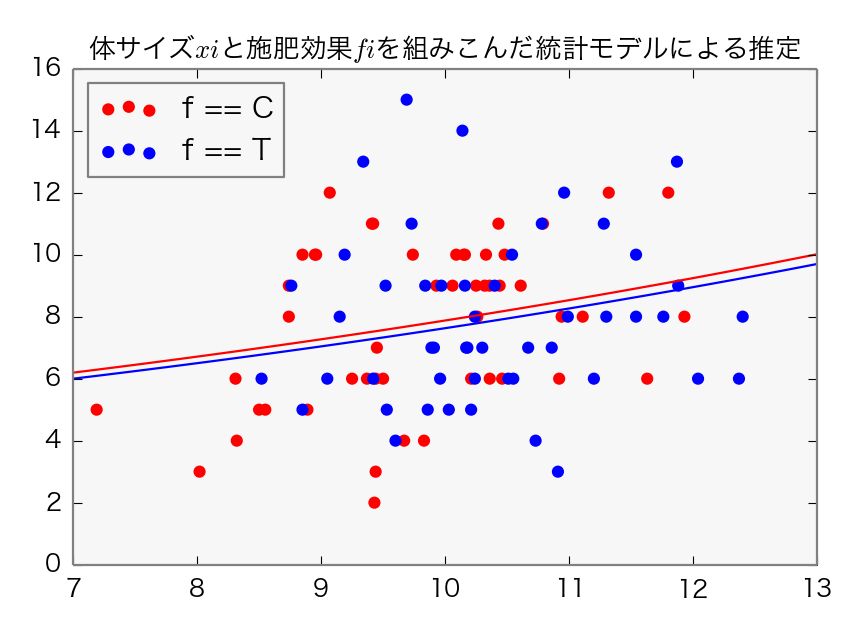

In [27]:
draw_scatter(df)
draw_estimate_x_f(x_f_related_model)
plt.xlim(7, 13)
plt.title(u'体サイズ$xi$と施肥効果$fi$を組みこんだ統計モデルによる推定')

In [28]:
glm('y ~ x + f', data=df, family=sm.families.Poisson(sm.families.links.identity)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.16
Date:                Wed, 11 Mar 2015   Deviance:                       84.538
Time:                        20:37:46   Pearson chi2:                     83.6
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2671      2.843      0.446      0.656        -4.306     6.840
f[T.T]        -0.2048      0.582     -0.352      0.725        -1.346     0.936
x              0.6606      0.290      2.281      0.023         0.093     1.228
==============================================================================
"""

AICで評価

In [17]:
x_related_model.aic

474.77250153972153

In [29]:
x_f_related_model.aic

476.58743848498739

In [30]:
f_related_model.aic

479.25451392137364